# Пример №1
В исходном видеофайле 2 танцующие девушки, слева - "коуч", справа - "обучаемая" девушка. Исходный видеофайл будет разбит на фреймы (кадры), модель обнаружит девушек, выделит ключевые точки, будет нанесен скелет, будут на каждый фрейм выведены метрики - косинусного расстояния и взвешенного совпадения.

## 1. Загрузка необходимых библиотек

In [1]:
import numpy as np
import math

import cv2
import torch
import os
from pathlib import Path
import glob

from tqdm import tqdm

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image, ImageReadMode
from pathlib import Path

from torchvision.utils import draw_keypoints
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## 2.Создадим необходимые папки, пропишем пути

In [2]:
# зададим папку с исходными фреймами
!mkdir frames
# зададим папку с обработанными фреймами
!mkdir frames_output
# зададим папку с итоговым видеофайлом
!mkdir output_video

In [3]:
# путь к исходному видеофайлу
PATH_TO_INPUT_VIDEO = "./input_video/video.mp4"
# путь к итоговому видеофайлу
PATH_TO_OUTPUT_VIDEO = "../output_video/"
# путь к исходным фреймам
PATH_TO_FRAMES = "../frames/"
# путь к обработанным фреймам
PATH_TO_OUTPUT_FRAMES = "../frames_output/"

## 3. Необходимые функции

In [4]:
def show(imgs):
    """
    Функция добавляет дополнительные метки на изображение и выводит его
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
def get_keypoints(keypoints):
  """
  Функция принисает на вход тензор с координатами ключевых точек и
  возращает пары координат [x,y] в виде массива [[x1,y1], [x2,y2], ...]
  """
  keypoints_list = []
  for i in range(len(keypoints[0])):
      x = round(float(keypoints[0][i][0].data),4)
      y = round(float(keypoints[0][i][1].data),4)
      keypoints_list.append([x,y])

  return np.asarray(keypoints_list)

In [6]:
def weight_distance(pose1, pose2, conf1):
    """
    Функция получает на вход в виде массивов ключевые точки входа и модели,
    а также score каждой точки входной позы в виде списка.
    Функция возвращает значения взвешенного совпадения по осям, т.е. ошибки по
    каждой оси.
    """
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||) = sum1 * sum2

    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    for i in range(len(pose1)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = math.floor(i / 2)
        sum2 = conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

## 4. Загрузим и разложим на кадры (фреймы) видеофайл

In [7]:
# определяем видеофайл для иззвлечения кадров
capture = cv2.VideoCapture(PATH_TO_INPUT_VIDEO)

frameNr = 0 # номер текущего кадра (с нуля)

# прогоняем видео, пока не закончатся кадры
while (True):

    success, frame = capture.read() # получаем кадр

    # если кадр успешно получен
    if success:
        cv2.imwrite(f'./frames/frame_{frameNr}.jpg', frame)

    else:
        break

    frameNr = frameNr+1

capture.release()

# узнаем количество полученных фреймов
os.chdir('./frames')
frames_count = len(list(Path('.').glob('*')))
print (f'Всего получено {frames_count} фреймов')

Всего получено 259 фреймов


## 5. Работа с тестовым фреймом

### 5.1. Нанесение ключевых точек и скелетов

[{'boxes': tensor([[ 337.6545,  437.8604,  615.9194,  935.8558],
        [   2.7013,  341.5034,  410.2616, 1074.0463],
        [ 102.2025,  356.1710,  325.6779,  914.4798],
        [ 510.6336,   98.0209,  549.4340,  167.6378],
        [ 417.7796,  846.1450,  440.7072,  875.4726],
        [ 480.2081,  145.6965,  513.6947,  170.5527],
        [ 213.0421,    7.0464,  708.6355,  279.1933],
        [  71.3847,   47.2542,  542.6034,  286.5616]],
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9999, 0.9999, 0.7616, 0.2579, 0.0906, 0.0744, 0.0727, 0.0724],
       grad_fn=<IndexBackward0>), 'keypoints': tensor([[[5.0221e+02, 4.8056e+02, 1.0000e+00],
         [5.1181e+02, 4.7192e+02, 1.0000e+00],
         [4.9166e+02, 4.7192e+02, 1.0000e+00],
         [5.2236e+02, 4.8248e+02, 1.0000e+00],
         [4.7727e+02, 4.8152e+02, 1.0000e+00],
         [5.2524e+02, 5.4485e+02, 1.0000e+00],
         [4.5328e+02, 5.3525e+02, 1.0000e+00],
         [5.0701e+0

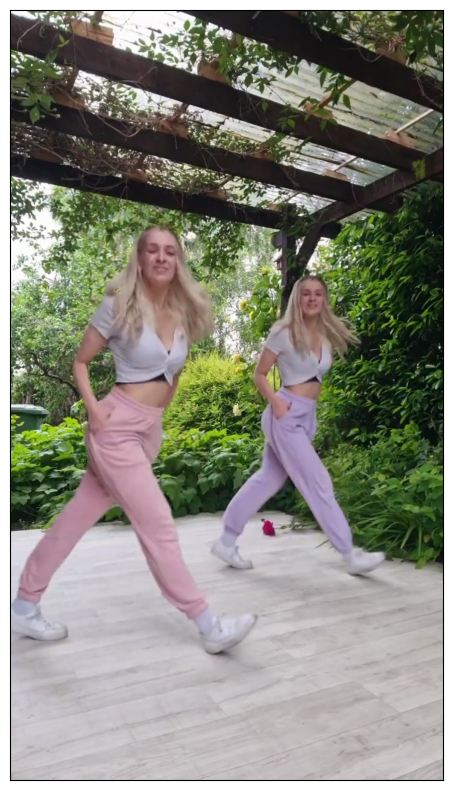

In [8]:
# загружаем тестовый фрейм
person_int = read_image(str(Path(PATH_TO_FRAMES + 'frame_10.jpg')), mode=ImageReadMode.RGB)


# используем веса предобученной keypointrcnn_resnet50_fpn сети
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

person_float = transforms(person_int)

# используем предобученную keypointrcnn_resnet50_fpn сеть
model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)

model = model.eval()

outputs = model([person_float])
show(person_int)
print(outputs)

In [9]:
# извлечем keypoints
kpts = outputs[0]['keypoints']
# извлечем scores
scores = outputs[0]['scores']

print(kpts.shape)
print(scores)

torch.Size([8, 17, 3])
tensor([0.9999, 0.9999, 0.7616, 0.2579, 0.0906, 0.0744, 0.0727, 0.0724],
       grad_fn=<IndexBackward0>)


**Промежуточный вывод:**
- Мы видим, что на тестовом фрейме модель нашла 8 объектов, мы также знаем что объектов на самом деле 2 (мы их видим со значениями *scores* = 0.9999) - это, собственно, 2 танцующих девушки. Остальное - "шум". Поэтому, detect_threshold должен быть больше 0.77 (в данном конкретном случае), то есть тогда возьмем его с "запасом" = 0.9
- Экспериментально установлено, что сначала в данных (по индексу = 0) идут данные тренирующейся девушки (она справа и сзади, ***input***), а следом (по индексу = 1) - данные "коуча" (***model***, девушка слева, ближе к нам)

In [10]:
detect_threshold = 0.9
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[5.0221e+02, 4.8056e+02, 1.0000e+00],
         [5.1181e+02, 4.7192e+02, 1.0000e+00],
         [4.9166e+02, 4.7192e+02, 1.0000e+00],
         [5.2236e+02, 4.8248e+02, 1.0000e+00],
         [4.7727e+02, 4.8152e+02, 1.0000e+00],
         [5.2524e+02, 5.4485e+02, 1.0000e+00],
         [4.5328e+02, 5.3525e+02, 1.0000e+00],
         [5.0701e+02, 6.0818e+02, 1.0000e+00],
         [4.1586e+02, 6.0626e+02, 1.0000e+00],
         [4.4176e+02, 6.5232e+02, 1.0000e+00],
         [4.4272e+02, 6.5232e+02, 1.0000e+00],
         [4.9742e+02, 6.7534e+02, 1.0000e+00],
         [4.5808e+02, 6.7726e+02, 1.0000e+00],
         [4.3505e+02, 7.7609e+02, 1.0000e+00],
         [5.1757e+02, 7.8569e+02, 1.0000e+00],
         [3.5828e+02, 8.8452e+02, 1.0000e+00],
         [5.6746e+02, 9.0755e+02, 1.0000e+00]],

        [[2.5022e+02, 4.1015e+02, 1.0000e+00],
         [2.6464e+02, 4.0343e+02, 1.0000e+00],
         [2.3580e+02, 3.9959e+02, 1.0000e+00],
         [2.7905e+02, 4.1975e+02, 1.0000e+00],
         [2

Теперь извлечем *keypoints* для обеих девушек в отдельные тензоры, сохранив в них размерность исходного тензора. Это необходимо для того, чтобы я мог использовать разные цвета для девушек на итоговом изображении, а также для расчета метрик.

In [11]:
keypoints.shape

torch.Size([2, 17, 3])

In [12]:
keypoints_input = keypoints[0].unsqueeze(0)
keypoints_model = keypoints[1].unsqueeze(0)
print(keypoints_input.shape)
print(keypoints_model.shape)

torch.Size([1, 17, 3])
torch.Size([1, 17, 3])


Визуализируем ключевые точки на изображении.

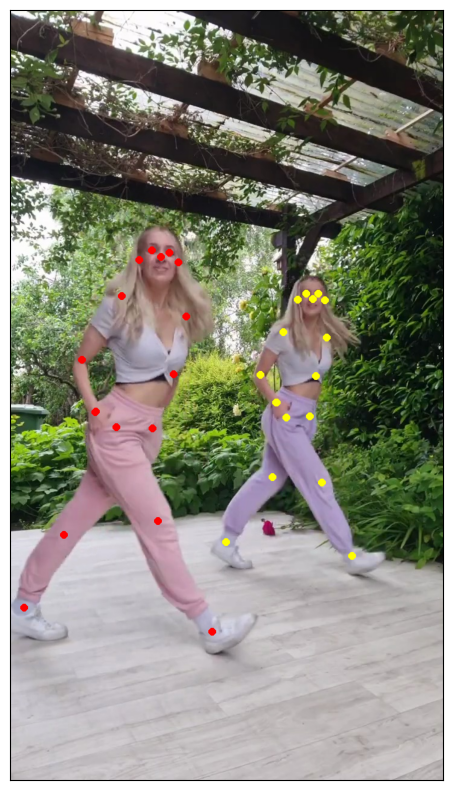

In [13]:
res_1 = draw_keypoints(person_int, keypoints_input, colors="yellow", radius=6)
res_2 = draw_keypoints(res_1, keypoints_model, colors="red", radius=6)
show(res_2)

Теперь добавим скелет.

In [14]:
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

In [15]:
connect_skeleton = [

        [coco_keypoints.index('right_eye'), coco_keypoints.index('nose')],
        [coco_keypoints.index('right_eye'), coco_keypoints.index('right_ear')],
        [coco_keypoints.index('left_eye'), coco_keypoints.index('nose')],
        [coco_keypoints.index('left_eye'), coco_keypoints.index('left_ear')],
        [coco_keypoints.index('right_shoulder'), coco_keypoints.index('right_elbow')],
        [coco_keypoints.index('right_elbow'), coco_keypoints.index('right_wrist')],
        [coco_keypoints.index('left_shoulder'), coco_keypoints.index('left_elbow')],
        [coco_keypoints.index('left_elbow'), coco_keypoints.index('left_wrist')],
        [coco_keypoints.index('right_hip'), coco_keypoints.index('right_knee')],
        [coco_keypoints.index('right_knee'), coco_keypoints.index('right_ankle')],
        [coco_keypoints.index('left_hip'), coco_keypoints.index('left_knee')],
        [coco_keypoints.index('left_knee'), coco_keypoints.index('left_ankle')],
        [coco_keypoints.index('right_shoulder'), coco_keypoints.index('left_shoulder')],
        [coco_keypoints.index('right_hip'), coco_keypoints.index('left_hip')],
        [coco_keypoints.index('right_shoulder'), coco_keypoints.index('right_hip')],
        [coco_keypoints.index('left_shoulder'), coco_keypoints.index('left_hip')]

]

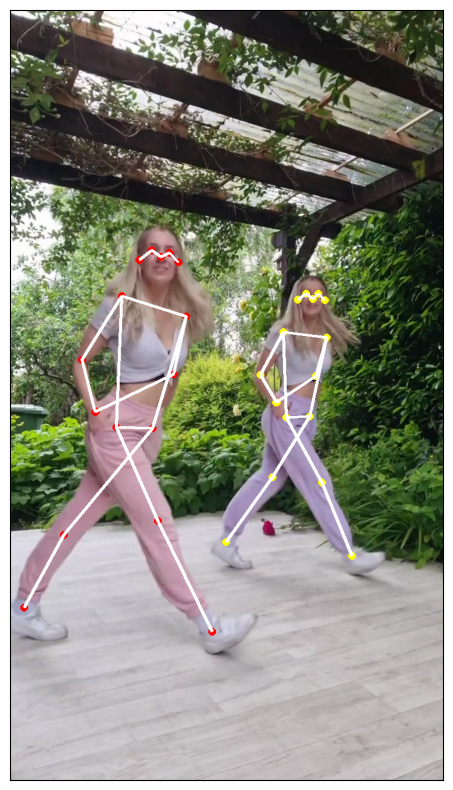

In [16]:
res_1 = draw_keypoints(person_int, keypoints_input, connectivity=connect_skeleton, colors="yellow", radius=6, width=5)
res_2 = draw_keypoints(res_1, keypoints_model, connectivity=connect_skeleton, colors="red", radius=6, width=5)
show(res_2)

**Выводы:**
- из исходного тестового фрейма нами получен тензор изображения, на котором разными цветами обозначены ключевые точки танцующих фигур, нанесены "скелеты" на обе фигуры
- на данном фрейме левые (относительно девушек) руки спрятаны за спины, что вносит ошибки в определении моделью ключевых точек и нанесения скелетов, однако эти ошибки одинаковы на обеих фигурах, что, по идее, не должно сильно влиять на вычисление метрик
- нужен ли нам в данном случае скелет по ключевым точкам на лице (глаза, нос и уши) ??? Я не разбираюсь в танцах и не знаю, влияет ли на оценку танца (если оценивает человек-специалист) положение головы, тут вопрос выходит за сферу моей компетенции

### 5.2. Вычисление косинусного и взвешенного расстояния

Получим необходимые данные для расчета метрик.

In [17]:
# получим score каждой точки входной позы в виде списка
keypoints_scores_input = outputs[0]['keypoints_scores'][0].tolist()
# получим keypoints модели и входа в виде массивов
keypoints_model = get_keypoints(keypoints_model)
keypoints_input = get_keypoints(keypoints_input)

Применение аффинного преобразования к входному изображению.

In [18]:
# С помощью расширенной матрицы можно осуществить умножение вектора x на матрицу A
# и добавление вектора b за счёт единственного матричного умножения.
# Расширенная матрица создаётся путём дополнения векторов "1" в конце.
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]

# Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]
Y = pad(keypoints_model)
X = pad(keypoints_input)

In [19]:
# Решим задачу наименьших квадратов X * A = Y
# и найдём матрицу аффинного преобразования A.
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

# Теперь, когда мы нашли расширенную матрицу A,
# мы можем преобразовать входной набор ключевых точек
transform = lambda x: unpad(np.dot(pad(x), A))
input_transform = transform(keypoints_input)

/var/folders/82/7qspv7mx2wj5rh25ylxc2jpr0000gn/T/ipykernel_27738/2578094340.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


#### Косинусное сходство ([источник](https://www.liberiangeek.net/2023/11/calculate-cosine-similarity-between-two-tensors-pytorch/))

Расчет по измерениям 0 и 1 (т.к. двухмерный массив)

In [20]:
cos_sim0 = torch.nn.CosineSimilarity(dim=0)
output_0 = cos_sim0(torch.from_numpy(keypoints_model), torch.from_numpy(input_transform))

cos_sim1 = torch.nn.CosineSimilarity(dim=1)
output_1 = cos_sim1(torch.from_numpy(keypoints_model), torch.from_numpy(input_transform))

print("Cosine Similarity in dim 0:",output_0)
print("Cosine Similarity in dim 1:",output_1)

Cosine Similarity in dim 0: tensor([0.9982, 0.9999], dtype=torch.float64)
Cosine Similarity in dim 1: tensor([1.0000, 0.9999, 1.0000, 0.9999, 1.0000, 1.0000, 0.9995, 0.9997, 0.9999,
        0.9999, 0.9999, 1.0000, 1.0000, 0.9987, 1.0000, 0.9998, 0.9999],
       dtype=torch.float64)


#### Взвешенное совпадение

Расчет по 2-м осям.

In [21]:
weighted_dist = weight_distance(input_transform, keypoints_model, keypoints_scores_input)
weighted_dist

array([0.64643196, 0.36068833])

### 5.3. Формируем итоговый фрейм

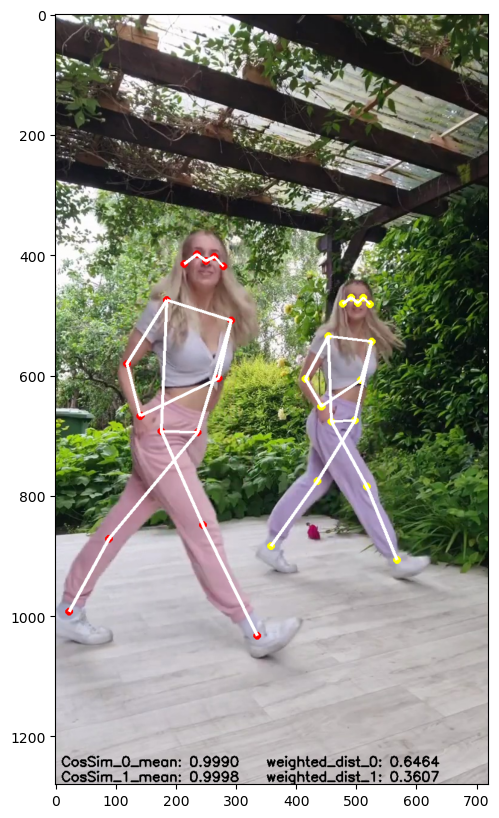

In [22]:
# tensor в массив numpy
numpy_image = res_2.numpy()
# меняем прядок осей
numpy_image = np.transpose(numpy_image, (1, 2, 0))
# конвертируем в rgb
rgb_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

# выводим метрики в виде текста

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.75
fontColor              = (0,0,0)
thickness              = 2
lineType               = 1

# выведем среднее значение косинусного сходства по оси 0
cv2.putText(rgb_image,f'CosSim_0_mean: {float(torch.mean(output_0)):.4f}',
    (10, numpy_image.shape[0] - 30),
    font,
    fontScale,
    fontColor,
    thickness,
    lineType)

# выведем среднее значение косинусного сходства по оси 1
cv2.putText(rgb_image,f'CosSim_1_mean: {float(torch.mean(output_1)):.4f}',
    (10, numpy_image.shape[0] - 5),
    font,
    fontScale,
    fontColor,
    thickness,
    lineType)

# выведем взвешенное совпадение по оси 0
cv2.putText(rgb_image,f'weighted_dist_0: {weighted_dist[0]:.4f}',
    (350, numpy_image.shape[0] - 30),
    font,
    fontScale,
    fontColor,
    thickness,
    lineType)

# выведем взвешенное совпадение по оси 1
cv2.putText(rgb_image,f'weighted_dist_1: {weighted_dist[1]:.4f}',
    (350, numpy_image.shape[0] - 5),
    font,
    fontScale,
    fontColor,
    thickness,
    lineType)

# выведем полученное изображение
plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.show()

**Выводы:**
- на тестовом фрейме выполнено нахождение и вывеедение на изображение ключевых точек поз и скелетов
- расчитаны метрики
- метрики нанесены на изображение

## 6. Обработа всех фреймов исходного видео

In [23]:
# обрабатываем последовательно все исходные фреймы
for i in tqdm(range(frames_count)):

    # загружаем i-й фрейм
    person_int = read_image(str(Path(PATH_TO_FRAMES + f'frame_{i}.jpg')), mode=ImageReadMode.RGB)

    # трансформация и прогон через сеть
    person_float = transforms(person_int)
    outputs = model([person_float])

    # извлечем все keypoints
    kpts = outputs[0]['keypoints']
    # извлечем scores
    scores = outputs[0]['scores']

    # выделим реальные keypoints 2-х девушек
    detect_threshold = 0.9
    idx = torch.where(scores > detect_threshold)
    keypoints = kpts[idx]

    # выделим отдельно keypoints каждой девушки
    keypoints_input = keypoints[0].unsqueeze(0) # тренирующаяся девушка (input) - справа
    keypoints_model = keypoints[1].unsqueeze(0) # коуч (model) - слева

    # наносим ключевые точки и скелет
    res_1 = draw_keypoints(person_int, keypoints_input, connectivity=connect_skeleton, colors="yellow", radius=6, width=5)
    res_2 = draw_keypoints(res_1, keypoints_model, connectivity=connect_skeleton, colors="red", radius=6, width=5)

    # вычисление косинусного расстояния и взвешенного совпадения

    # получим score каждой точки входной позы в виде списка
    keypoints_scores_input = outputs[0]['keypoints_scores'][0].tolist()
    # получим keypoints модели и входа в виде массивов
    keypoints_model = get_keypoints(keypoints_model)
    keypoints_input = get_keypoints(keypoints_input)

    # С помощью расширенной матрицы можно осуществить умножение вектора x на матрицу A
    # и добавление вектора b за счёт единственного матричного умножения.
    # Расширенная матрица создаётся путём дополнения векторов "1" в конце.
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]

    # Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]
    Y = pad(keypoints_model)
    X = pad(keypoints_input)

    # Решим задачу наименьших квадратов X * A = Y
    # и найдём матрицу аффинного преобразования A.
    A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None) # добавлен rcond=None, чтобы не было предупреждений
    A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

    # Теперь, когда мы нашли расширенную матрицу A,
    # мы можем преобразовать входной набор ключевых точек
    transform = lambda x: unpad(np.dot(pad(x), A))
    input_transform = transform(keypoints_input)

    # косинусное расстояние по оси 0
    cos_sim0 = torch.nn.CosineSimilarity(dim=0)
    output_0 = cos_sim0(torch.from_numpy(keypoints_model), torch.from_numpy(input_transform))
    # косинусное расстояние по оси 1
    cos_sim1 = torch.nn.CosineSimilarity(dim=1)
    output_1 = cos_sim1(torch.from_numpy(keypoints_model), torch.from_numpy(input_transform))
    # взвешенное совпадение
    weighted_dist = weight_distance(input_transform, keypoints_model, keypoints_scores_input)

    # пробразование полученного тензора в итоговое изображение

    # tensor в массив numpy
    numpy_image = res_2.numpy()
    # меняем прядок осей
    numpy_image = np.transpose(numpy_image, (1, 2, 0))
    # конвертируем в rgb
    rgb_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

    # выводим метрики в виде текста

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.75
    fontColor              = (0,0,0)
    thickness              = 2
    lineType               = 1

    # выведем среднее значение косинусного сходства по оси 0
    cv2.putText(rgb_image,f'CosSim_0_mean: {float(torch.mean(output_0)):.4f}',
        (10, numpy_image.shape[0] - 30),
        font,
        fontScale,
        fontColor,
        thickness,
        lineType)

    # выведем среднее значение косинусного сходства по оси 1
    cv2.putText(rgb_image,f'CosSim_1_mean: {float(torch.mean(output_1)):.4f}',
        (10, numpy_image.shape[0] - 5),
        font,
        fontScale,
        fontColor,
        thickness,
        lineType)

    # выведем взвешенное совпадение по оси 0
    cv2.putText(rgb_image,f'weighted_dist_0: {weighted_dist[0]:.4f}',
        (350, numpy_image.shape[0] - 30),
        font,
        fontScale,
        fontColor,
        thickness,
        lineType)

    # выведем взвешенное совпадение по оси 1
    cv2.putText(rgb_image,f'weighted_dist_1: {weighted_dist[1]:.4f}',
        (350, numpy_image.shape[0] - 5),
        font,
        fontScale,
        fontColor,
        thickness,
        lineType)

    # сохраняем итоговый фрейм
    cv2.imwrite(PATH_TO_OUTPUT_FRAMES + f'frame_{i}.jpg', rgb_image)

100%|██████████| 259/259 [04:18<00:00,  1.00it/s]


## 7. Сборка и сохранение итогового видео

In [24]:
# папка с фреймами
image_folder = '../frames_output/*'
# место сохранения итогового видео
video_name = PATH_TO_OUTPUT_VIDEO + 'output.avi'

# разрешение видео
width = rgb_image.shape[1]
height = rgb_image.shape[0]

# настройки
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video=cv2.VideoWriter(video_name,fourcc, 2.0, (width,height))



for i in tqdm((sorted(glob.glob(image_folder),key=os.path.getmtime))):
     x=cv2.imread(i)
     video.write(x)

cv2.destroyAllWindows()
video.release()

100%|██████████| 259/259 [00:03<00:00, 72.82it/s]


# Выводы:
- для проекта использована сеть ***keypointrcnn_resnet50_fpn*** 
- на примере тестового видео выполненено детектирование объектов (2 танцующие фигуры), наложены ключевые точки и скелет
- вычислены значения метрик косинусного расстояния и взвешенного совпадения
- получен итоговый видеофайл, на котором отрисованы ключевые точки и скелет, в режиме реального времени выводятся значения метрик

- возникла проблема (!) - если внимательно смотреть итоговое видео, то можно заметить, что на некоторых фреймах модель неправильно "помечает" коуча и тренирующеюся девушку, связано это с тем, что порядок в данных определяется вероятностью правильного детектирования объекта, и на некотрых фреймах вероятности меняются. Эта проблема будет решена в следующем примере: *example_2*